# What is Pneumonia?

Pneumonia is a lung infection that inflames the alveoli, causing symptoms like cough (dry or productive), fever, chest pain, and breathing difficulties. It can range from mild to severe and is most commonly caused by bacteria or viruses, less often by other organisms, medications, or conditions like autoimmune diseases. Risk factors include COPD, asthma, diabetes, heart failure, smoking, stroke-related cough impairment, and weakened immunity. Diagnosis is based on symptoms, physical exam, chest X-ray, blood tests, and sometimes sputum culture. It’s classified by where it’s acquired—community, hospital, or healthcare-associated.

![Pneumonia Image](https://www.researchgate.net/publication/344488922/figure/fig1/AS:11431281256664885@1719559336841/The-lungs-and-chest-X-rays-showing-inflammation-leading-to-pneumonia-A-The-lung.jpg)

## Importing Libraries

In [ ]:
from google.colab import userdata
import os
import shutil
import random
import hashlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## Importing Dataset

In [ ]:
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [ ]:
!kaggle datasets list -s 'chest-xray-pneumonia'

ref                                                              title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset    COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset       2053474983  2020-07-13 05:54:22.483000           3639         32  0.8125           
divyam6969/chest-xray-pneumonia-dataset                          Chest XRAY - Pneumonia Dataset                       1151535496  2024-01-17 12:19:16.570000            644         22  0.6875           
khoongweihao/covid19-xray-dataset-train-test-sets                COVID-19 Xray Dataset (Train & Test Sets)              88399353  2020-03-19 01:49:56.503000          12663        194  0.875   

In [ ]:
!kaggle datasets download -d 'paultimothymooney/chest-xray-pneumonia'

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:17<00:00, 250MB/s]
100% 2.29G/2.29G [00:17<00:00, 142MB/s]


In [ ]:
!sudo apt-get install unzip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!unzip chest-xray-pneumonia.zip -d ./data/

Streaming output truncated to the last 5000 lines.
  inflating: ./data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: ./data/chest_xr

## Data Organization

In [ ]:
def organize_chest_xray_data(
    source_normal,
    source_pneumonia,
    output_train_dir,
    copy=True,
    verbose=True
):
    """
    Organizes chest X-ray data into clean subdirectories:
        output_train_dir/
        ├── normal/
        ├── bacterial_pneumonia/
        └── viral_pneumonia/

    Args:
        source_normal (str): Path to the NORMAL images folder.
        source_pneumonia (str): Path to the PNEUMONIA images folder.
        output_train_dir (str): Path to output 'train' directory.
        copy (bool): If True, copies files. If False, moves them (deletes originals).
        verbose (bool): If True, prints progress and unknown files.
    """
    # Define class directories
    class_dirs = ['normal', 'bacterial_pneumonia', 'viral_pneumonia']

    # Create output directories
    for class_dir in class_dirs:
        os.makedirs(os.path.join(output_train_dir, class_dir), exist_ok=True)

    # Select function: copy or move
    file_op = shutil.copy if copy else shutil.move
    op_name = "Copying" if copy else "Moving"

    if verbose:
        print(f"🚀 Starting {op_name.lower()} files to {output_train_dir}...")

    # Copy/move normal images
    if verbose:
        print(f"📁 Processing normal images from {source_normal}...")
    for fname in os.listdir(source_normal):
        src = os.path.join(source_normal, fname)
        if os.path.isfile(src):
            dst = os.path.join(output_train_dir, 'normal', fname)
            file_op(src, dst)

    # Copy/move pneumonia images with classification
    if verbose:
        print(f"📁 Processing pneumonia images from {source_pneumonia}...")
    for fname in os.listdir(source_pneumonia):
        src = os.path.join(source_pneumonia, fname)
        if not os.path.isfile(src):
            continue

        dst = None
        if 'bacteria' in fname.lower():
            dst = os.path.join(output_train_dir, 'bacterial_pneumonia', fname)
        elif 'virus' in fname.lower():
            dst = os.path.join(output_train_dir, 'viral_pneumonia', fname)
        else:
            if verbose:
                print(f"⚠️  Unknown pneumonia type (no 'bacteria' or 'virus' in name): {fname}")
            continue  # Skip if no clear label

        file_op(src, dst)

    print(f"✅ Data successfully organized into: {output_train_dir}")

In [ ]:
OUTPUT_DIR = 'organized_data'
SOURCE_DIR = './data/chest_xray'

In [ ]:
organize_chest_xray_data(
    source_normal= SOURCE_DIR + '/train/NORMAL',
    source_pneumonia= SOURCE_DIR + '/train/PNEUMONIA',
    output_train_dir= OUTPUT_DIR + '/train',
    copy=False,
    verbose=True
)

🚀 Starting moving files to organized_data/train...
📁 Processing normal images from ./data/chest_xray/train/NORMAL...
📁 Processing pneumonia images from ./data/chest_xray/train/PNEUMONIA...
✅ Data successfully organized into: organized_data/train


In [ ]:
organize_chest_xray_data(
    source_normal= SOURCE_DIR + '/test/NORMAL',
    source_pneumonia= SOURCE_DIR + '/test/PNEUMONIA',
    output_train_dir= OUTPUT_DIR + '/test',
    copy=False,
    verbose=True
)

🚀 Starting moving files to organized_data/test...
📁 Processing normal images from ./data/chest_xray/test/NORMAL...
📁 Processing pneumonia images from ./data/chest_xray/test/PNEUMONIA...
✅ Data successfully organized into: organized_data/test


In [ ]:
organize_chest_xray_data(
    source_normal= SOURCE_DIR + '/val/NORMAL',
    source_pneumonia= SOURCE_DIR + '/val/PNEUMONIA',
    output_train_dir= OUTPUT_DIR + '/val',
    copy=False,
    verbose=True
)

🚀 Starting moving files to organized_data/val...
📁 Processing normal images from ./data/chest_xray/val/NORMAL...
📁 Processing pneumonia images from ./data/chest_xray/val/PNEUMONIA...
✅ Data successfully organized into: organized_data/val


## Inspecting the number of images

Setup the dictionary to hold the images count

In [ ]:
splits = ['train', 'val', 'test']
classes = ['bacterial_pneumonia', 'normal', 'viral_pneumonia']
counts = {split: {cls: 0 for cls in classes} for split in splits}

for split in splits:
    for cls in classes:
        class_path = os.path.join(OUTPUT_DIR, split, cls)
        if os.path.exists(class_path):
            counts[split][cls] = len(os.listdir(class_path))
        else:
            print(f"Warning: {class_path} does not exist.")

Prepare to plot the bar chart to have visuals over the data

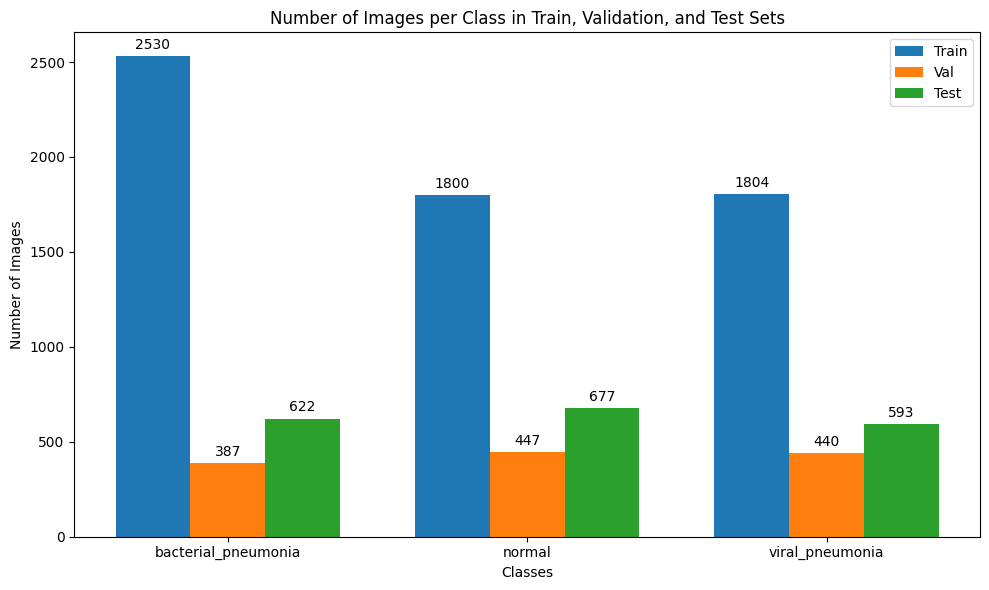

In [ ]:
x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, split in enumerate(splits):
    values = [counts[split][cls] for cls in classes]
    ax.bar(x + i * width, values, width, label=split.capitalize())

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class in Train, Validation, and Test Sets')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend()

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.tight_layout()
plt.show()

## Adding a different Dataset due to classes imbalance

In [ ]:
!kaggle datasets list -s 'Pneumonia_dataset'

ref                                                           title                                               size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
nkifor/pneumonia-dataset                                      Pneumonia_dataset                             1145256149  2023-07-16 22:25:26.317000            163          3  0.75             
abibb5/pneumonia-dataset                                      pneumonia_dataset                             1228983681  2024-02-04 10:04:49.763000              5          1  0.25             
tonystark070/pneumonia-dataset                                Pneumonia_Dataset                             1437582716  2022-03-01 15:10:33.797000              7          1  0.125            
andreirudoi/pneumonia-dataset           

In [ ]:
!kaggle datasets download -d 'nkifor/pneumonia-dataset'

Dataset URL: https://www.kaggle.com/datasets/nkifor/pneumonia-dataset 
License(s): CC-BY-SA-4.0
 93% 0.99G/1.07G [00:11<00:03, 25.7MB/s]
100% 1.07G/1.07G [00:11<00:00, 98.7MB/s]


In [ ]:
!unzip pneumonia-dataset.zip -d ./new_data/

Streaming output truncated to the last 5000 lines.
  inflating: ./new_data/xraychest/Normal/IM-0419-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0420-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0421-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0423-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0424-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0425-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0427-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0428-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0429-0001-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0429-0001-0002.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0429-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0430-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0431-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0432-0001.jpeg  
  inflating: ./new_data/xraychest/Normal/IM-0433-0001.jpeg  
  inflating: ./new_data/

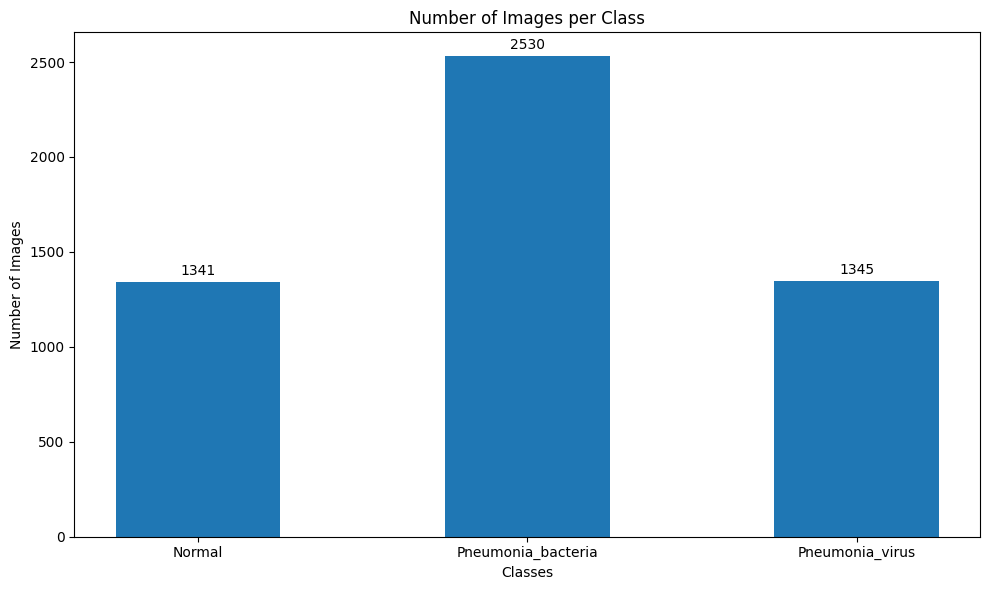

In [ ]:
# Define classes
classes = ['Normal', 'Pneumonia_bacteria', 'Pneumonia_virus']

# Initialize counts
counts = {}

# Count images in each class folder
for cls in classes:
    class_path = os.path.join('./new_data/xraychest', cls)
    if os.path.exists(class_path):
        counts[cls] = len(os.listdir(class_path))
    else:
        print(f"Warning: {class_path} does not exist.")
        counts[cls] = 0

# Plotting
x = np.arange(len(classes))  # label locations
width = 0.5  # width of bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bar plot
values = [counts[cls] for cls in classes]
bars = ax.bar(x, values, width, label='Total Images')

# Labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)

# Add count labels on top of each bar
ax.bar_label(bars, padding=3)

plt.tight_layout()
plt.show()

In [ ]:
def generate_file_hash(filepath, hash_algo='sha256'):
    """Generate a hash of the file content to detect duplicates."""
    h = hashlib.new(hash_algo)
    with open(filepath, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b""):
            h.update(chunk)
    return h.hexdigest()

def organize_xray_data_safe_move(
    source_dir='./new_data/xraychest',
    dest_dir='./organized_data',
    class_mapping=None,
    split=(0.7, 0.15, 0.15),
    random_seed=42,
    use_hash_dedup=True,
    rename_format="{cls}_{idx:04d}{ext}"
):
    """
    Moves and renames X-ray images with unique names to avoid collisions.
    Optionally uses file hashing to avoid moving duplicates.
    """
    random.seed(random_seed)
    os.makedirs(dest_dir, exist_ok=True)

    # Default class mapping
    if class_mapping is None:
        class_mapping = {
            'Normal': 'normal',
            'pneumonia_bacteria': 'bacterial_pneumonia',
            'Pneumonia_virus': 'viral_pneumonia'
        }

    train_ratio, val_ratio, test_ratio = split
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Split ratios must sum to 1.0"

    # Track hashes (if deduplication is enabled) and counters for naming
    seen_hashes = set() if use_hash_dedup else None
    class_counters = {v: 0 for v in class_mapping.values()}

    # Collect all files grouped by original class
    all_files = []  # (src_path, old_class, new_class)
    for old_class in os.listdir(source_dir):
        old_class_path = os.path.join(source_dir, old_class)
        if not os.path.isdir(old_class_path) or old_class not in class_mapping:
            print(f"⚠️ Skipping: {old_class_path} (not a valid class or not found)")
            continue

        images = [
            f for f in os.listdir(old_class_path)
            if os.path.isfile(os.path.join(old_class_path, f))
        ]

        if not images:
            print(f"🟡 No images found in {old_class_path}")
            continue

        new_class = class_mapping[old_class]
        for img in images:
            all_files.append((os.path.join(old_class_path, img), old_class, new_class))

    if len(all_files) == 0:
        print("❌ No valid image files found to process.")
        return

    # Group files by new_class and shuffle each group (stratified split)
    from collections import defaultdict
    class_groups = defaultdict(list)
    for src_path, old_class, new_class in all_files:
        class_groups[new_class].append(src_path)

    # Process each class
    for new_class, file_paths in class_groups.items():
        random.shuffle(file_paths)
        n = len(file_paths)
        train_end = int(train_ratio * n)
        val_end = train_end + int(val_ratio * n)

        splits = {
            'train': file_paths[:train_end],
            'val': file_paths[train_end:val_end],
            'test': file_paths[val_end:]
        }

        for split_name, paths in splits.items():
            dest_class_dir = os.path.join(dest_dir, split_name, new_class)
            os.makedirs(dest_class_dir, exist_ok=True)

            for src_path in paths:
                ext = os.path.splitext(src_path)[1].lower()
                # Optional: skip non-image files
                if ext not in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
                    print(f"Skipping non-image file: {src_path}")
                    continue

                # Check for duplicate content
                file_hash = None
                if use_hash_dedup:
                    file_hash = generate_file_hash(src_path)
                    if file_hash in seen_hashes:
                        print(f"🚫 Duplicate content (skipped): {src_path}")
                        continue
                    seen_hashes.add(file_hash)

                # Generate unique name
                class_counters[new_class] += 1
                new_filename = rename_format.format(cls=new_class, idx=class_counters[new_class], ext=ext)
                dst_path = os.path.join(dest_class_dir, new_filename)

                # Move the file
                try:
                    shutil.move(src_path, dst_path)
                    print(f"✅ Moved → {new_filename} ({new_class}, {split_name})")
                except Exception as e:
                    print(f"❌ Failed to move {src_path}: {e}")

        print(f"📁 {new_class.capitalize()}: Split into "
              f"Train={len(splits['train'])}, Val={len(splits['val'])}, Test={len(splits['test'])}")

    # Final message
    print(f"\n🎉 Success! All images have been moved and organized into:\n   {dest_dir}")

    # Cleanup empty source directories
    for old_class in class_mapping.keys():
        old_class_path = os.path.join(source_dir, old_class)
        if os.path.exists(old_class_path) and os.path.isdir(old_class_path) and not os.listdir(old_class_path):
            os.rmdir(old_class_path)
            print(f"🗑️  Removed empty directory: {old_class_path}")

    if os.path.exists(source_dir) and os.path.isdir(source_dir) and not os.listdir(source_dir):
        os.rmdir(source_dir)
        print(f"🗑️  Removed empty source root: {source_dir}")

# === RUN THE FUNCTION ===
organize_xray_data_safe_move()

⚠️ Skipping: ./new_data/xraychest/Pneumonia_bacteria (not a valid class or not found)
✅ Moved → normal_0001.jpeg (normal, train)
✅ Moved → normal_0002.jpeg (normal, train)
✅ Moved → normal_0003.jpeg (normal, train)
✅ Moved → normal_0004.jpeg (normal, train)
✅ Moved → normal_0005.jpeg (normal, train)
✅ Moved → normal_0006.jpeg (normal, train)
✅ Moved → normal_0007.jpeg (normal, train)
✅ Moved → normal_0008.jpeg (normal, train)
✅ Moved → normal_0009.jpeg (normal, train)
✅ Moved → normal_0010.jpeg (normal, train)
✅ Moved → normal_0011.jpeg (normal, train)
✅ Moved → normal_0012.jpeg (normal, train)
✅ Moved → normal_0013.jpeg (normal, train)
✅ Moved → normal_0014.jpeg (normal, train)
✅ Moved → normal_0015.jpeg (normal, train)
✅ Moved → normal_0016.jpeg (normal, train)
✅ Moved → normal_0017.jpeg (normal, train)
✅ Moved → normal_0018.jpeg (normal, train)
✅ Moved → normal_0019.jpeg (normal, train)
✅ Moved → normal_0020.jpeg (normal, train)
✅ Moved → normal_0021.jpeg (normal, train)
✅ Moved → n

## Data Pre-processing and cleaning

We will use MobileNetV2 as a base model which was trained on ImageNet where input images are 224x224x3. Our images are greyscale so we need to duplicate the grayscale channel 3 times. Then we need to normalize the images for faster training and stability.

### Define Image loader and Pre-processer

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

# No data augmentation, only preprocessing
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_dir = OUTPUT_DIR + '/train'
val_dir = OUTPUT_DIR + '/val'
test_dir = OUTPUT_DIR + '/test'

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',  # Convert grayscale to 3-channel RGB
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important: keeps order for metrics like confusion matrix
)

print(train_generator.class_indices)

Found 6134 images belonging to 3 classes.
Found 1274 images belonging to 3 classes.
Found 1892 images belonging to 3 classes.
{'bacterial_pneumonia': 0, 'normal': 1, 'viral_pneumonia': 2}


## Now we will build the MobileNetV2 Model

In [ ]:
# Load MobileNetV2 base (no top layer)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze feature extractor

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Now we will train the model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.4274 - loss: 1.1427 - val_accuracy: 0.6868 - val_loss: 0.7739
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.6375 - loss: 0.8094 - val_accuracy: 0.7347 - val_loss: 0.6422
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.7013 - loss: 0.6856 - val_accuracy: 0.7512 - val_loss: 0.5929
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.7298 - loss: 0.6385 - val_accuracy: 0.7622 - val_loss: 0.5619
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.7446 - loss: 0.6085 - val_accuracy: 0.7582 - val_loss: 0.5485
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.7559 - loss: 0.5689 - val_accuracy: 0.7535 - val_loss: 0.5459
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.7593 - loss: 0.5520 - val_accuracy: 0.7598 - val_loss: 0.5250
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.7593 - loss: 0.5540 - val_accu

## Now We will Evaluate the Model on Test set

In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8638 - loss: 0.4288
Test Accuracy: 80.02%


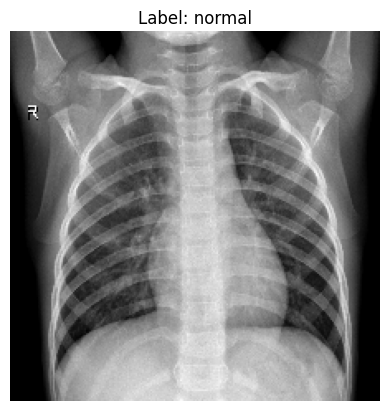

In [ ]:
# Get a batch
x_batch, y_batch = next(train_generator)

# Inverse MobileNetV2 preprocessing
img_to_display = (x_batch[0] + 1) * 127.5

# Class label map
label_map = {v: k for k, v in train_generator.class_indices.items()}
true_label = label_map[np.argmax(y_batch[0])]

plt.imshow(img_to_display.astype('uint8'))
plt.title(f"Label: {true_label}")
plt.axis(False)
plt.show()

### Training History

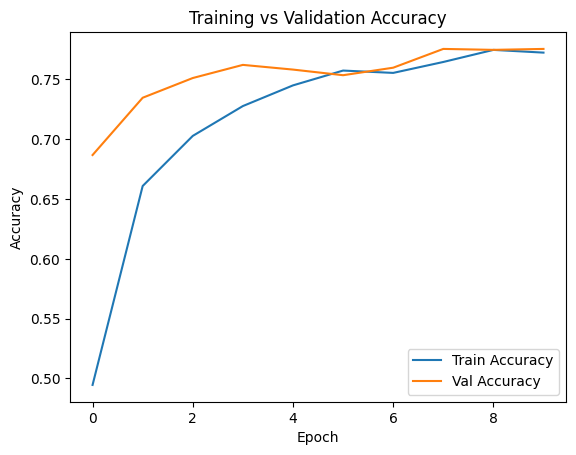

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

### Confusion Matrix

60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step


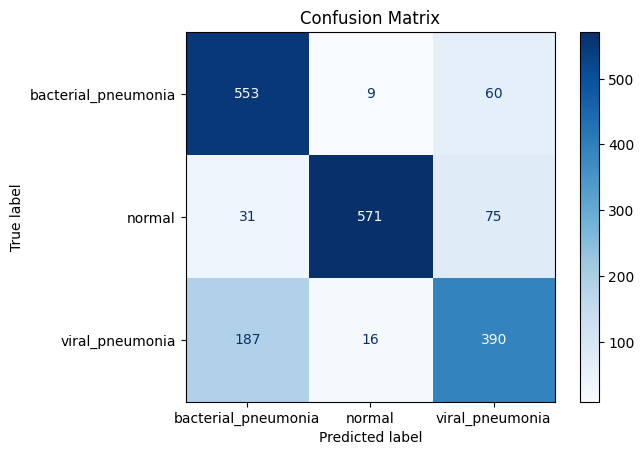

In [ ]:
# Predict on test_generator (make sure shuffle=False in test_generator)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels are in test_generator.classes
y_true = test_generator.classes

# Map integer labels to class names
labels = list(train_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

### Metrics

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels))

                     precision    recall  f1-score   support

bacterial_pneumonia       0.72      0.89      0.79       622
             normal       0.96      0.84      0.90       677
    viral_pneumonia       0.74      0.66      0.70       593

           accuracy                           0.80      1892
          macro avg       0.81      0.80      0.80      1892
       weighted avg       0.81      0.80      0.80      1892

